- adicionar evitar errors de digitacao
- podemos adicionar uma contagem de termos para fazer o wordcloud em descricoes

In [1]:

import networkx as nx
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import requests
from geopy.geocoders import Nominatim
from concurrent.futures import ThreadPoolExecutor
import numpy as np
import math
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import networkx as nx
from wordcloud import WordCloud

In [2]:
G = nx.read_graphml('../graphs/coauthorship_graph.xml')

In [3]:
df_end = pd.read_csv('../data/processed/aplicacoes/enderecos.csv')
df_pesq = pd.read_csv('../data/processed/aplicacoes/gerais.csv')
df_co = pd.read_csv('../data/processed/aplicacoes/coauthorship_weighted.csv')

In [4]:

max(np.unique(np.array(G.nodes()), return_counts=True)[1])

1

# Análise Dataset

In [5]:
def print_dataframe_status(df):
    
    print(f'Shape: {df.shape}')
    print('Contagem de dados nulos:')
    display(df.isna().sum())
    print('Amostra do dataset:')
    display(df.head())

def print_value_counts(df, top_n, columns):

    # ------------------------------------------------------------
    # 4. ANÁLISE DESCRITIVA:
    #    Exibir as 5 categorias mais frequentes de cada coluna e a contagem
    # ------------------------------------------------------------
    print(f"\n=== ANÁLISE DESCRITIVA (TOP {top_n} POR COLUNA) ===\n")
    for col in columns:
        print(f"Coluna: {col}")
        print(df[col].value_counts(dropna=False).head(top_n))
        print("-" * 50)
        
def plot_df_columns_wordcloud(df,columns):


    for col in columns:
        # 1) Conta quantas vezes aparece cada país
        freq = df[col].value_counts().to_dict()

        # 2) Cria o objeto WordCloud e gera a nuvem a partir das frequências
        wc = WordCloud(width=800, height=400)
        wc.generate_from_frequencies(freq)

        # 3) Plota a nuvem
        plt.figure(figsize=(10, 5))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.show()


## Gerais

In [6]:
print_dataframe_status(df_pesq)


Shape: (3992, 9)
Contagem de dados nulos:


LattesID                  0
NOME-COMPLETO             0
DATA-ATUALIZACAO          0
HORA-ATUALIZACAO          0
CIDADE-NASCIMENTO        42
UF-NASCIMENTO           272
PAIS-DE-NASCIMENTO        0
NACIONALIDADE             0
DATA-DE-FALECIMENTO    3992
dtype: int64

Amostra do dataset:


LattesID                  NOME-COMPLETO  DATA-ATUALIZACAO  \
0    565598534943           Sdnei de Brito Alves          25012007   
1    601083852823  Alexandre Loureiros Rodrigues          12072021   
2   5349558315095           Juliano Manabu Iyoda          24092021   
3  10858860721392           Hugo Bastos de Paula           2032021   
4  11303079806761      Gerald Jean Francis Banon           3062014   

   HORA-ATUALIZACAO CIDADE-NASCIMENTO UF-NASCIMENTO PAIS-DE-NASCIMENTO  \
0            120204           Itajubá            BA             Brasil   
1            204404           Vitória            ES             Brasil   
2            105006            Recife            PE             Brasil   
3             83521    Belo Horizonte            MG             Brasil   
4            113408             Paris           NaN             França   

  NACIONALIDADE  DATA-DE-FALECIMENTO  
0             B                  NaN  
1             B                  NaN  
2             B                  NaN  
3             B                  NaN  
4             B                  NaN

In [7]:
print_value_counts(df_pesq, 5, df_pesq.columns)


=== ANÁLISE DESCRITIVA (TOP 5 POR COLUNA) ===

Coluna: LattesID
LattesID
565598534943        1
6519916148844251    1
6489257938942420    1
6494676052801758    1
6496119903436467    1
Name: count, dtype: int64
--------------------------------------------------
Coluna: NOME-COMPLETO
NOME-COMPLETO
Sdnei de Brito Alves             1
Ascendino Flávio Dias e Silva    1
Janilson Pinheiro de Assis       1
Adriana Santarosa Vivacqua       1
Paulo Balduino Flabes Neto       1
Name: count, dtype: int64
--------------------------------------------------
Coluna: DATA-ATUALIZACAO
DATA-ATUALIZACAO
4032022     58
30092021    52
2032022     47
27092021    43
24022022    42
Name: count, dtype: int64
--------------------------------------------------
Coluna: HORA-ATUALIZACAO
HORA-ATUALIZACAO
123530    3
113458    3
140714    3
224201    2
141515    2
Name: count, dtype: int64
--------------------------------------------------
Coluna: CIDADE-NASCIMENTO
CIDADE-NASCIMENTO
São Paulo         283
Rio de Janei

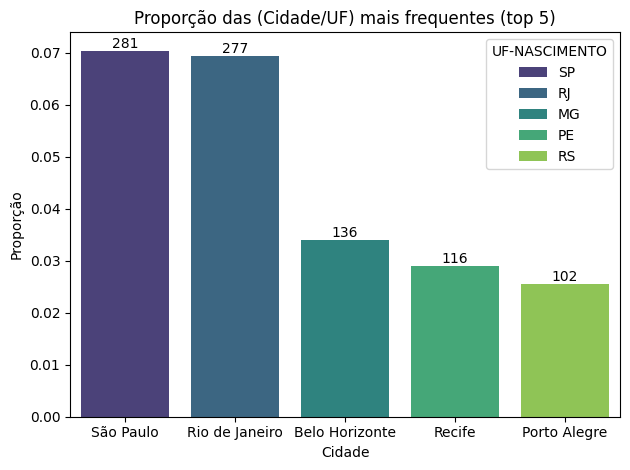

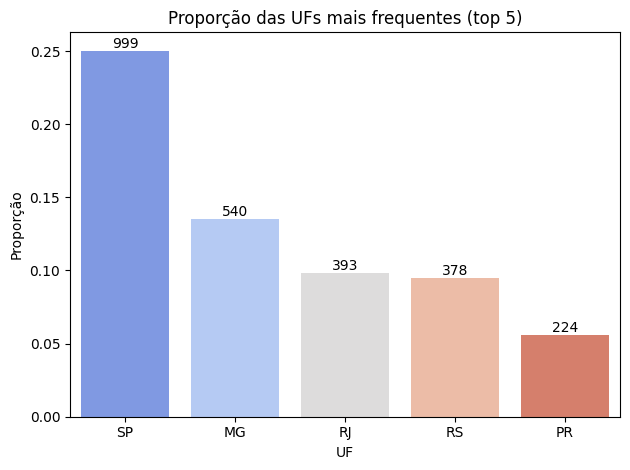

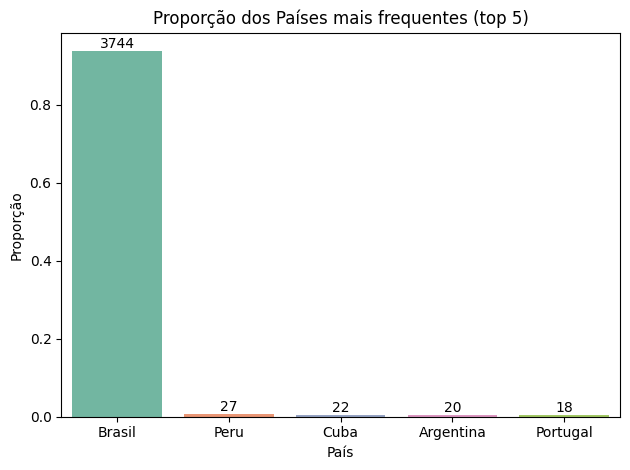

In [8]:
# ------------------------------------------------------------
# Parâmetro: número máximo de categorias (barras) a exibir
# ------------------------------------------------------------
n = 5  # Ajuste conforme necessário (ex: 5, 10, etc.)

# ============================================================
# 1. Gráfico de Barra - (CIDADE-NASCIMENTO, UF-NASCIMENTO)
# ============================================================
df_city_uf = (
    df_pesq
    .groupby(["CIDADE-NASCIMENTO", "UF-NASCIMENTO"])
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
    .head(n)
)
df_city_uf["proportion"] = df_city_uf["count"] / df_pesq.shape[0]

plt.figure()
ax_city_uf = sns.barplot(
    data=df_city_uf,
    x="CIDADE-NASCIMENTO",
    y="proportion",
    hue="UF-NASCIMENTO",  # Aqui já temos o hue definido, logo não há aviso
    palette="viridis"
)
plt.title(f"Proporção das (Cidade/UF) mais frequentes (top {n})")
plt.xlabel("Cidade")
plt.ylabel("Proporção")

# Adicionando a contagem sobre cada barra
for patch, (_, row) in zip(ax_city_uf.patches, df_city_uf.iterrows()):
    height = patch.get_height()
    ax_city_uf.annotate(
        f'{int(row["count"])}',
        (patch.get_x() + patch.get_width() / 2., height),
        ha='center', va='center', textcoords='offset points', xytext=(0, 5)
    )
plt.tight_layout()
plt.show()

# ============================================================
# 2. Gráfico de Barra - UF-NASCIMENTO
# ============================================================
df_uf = (
    df_pesq
    .groupby("UF-NASCIMENTO")
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
    .head(n)
)
df_uf["proportion"] = df_uf["count"] / df_pesq.shape[0]

plt.figure()
# Para evitar o aviso, utilizamos o mesmo valor de 'UF-NASCIMENTO' para o argumento hue
ax_uf = sns.barplot(
    data=df_uf,
    x="UF-NASCIMENTO",
    y="proportion",
    hue="UF-NASCIMENTO",  # atribuindo hue
    palette="coolwarm"
)
# Remove a legenda para não duplicar informação
if ax_uf.get_legend() is not None:
    ax_uf.get_legend().remove()

plt.title(f"Proporção das UFs mais frequentes (top {n})")
plt.xlabel("UF")
plt.ylabel("Proporção")

for patch, (_, row) in zip(ax_uf.patches, df_uf.iterrows()):
    height = patch.get_height()
    ax_uf.annotate(
        f'{int(row["count"])}', 
        (patch.get_x() + patch.get_width() / 2., height),
        ha='center', va='center', textcoords='offset points', xytext=(0, 5)
    )
plt.tight_layout()
plt.show()

# ============================================================
# 3. Gráfico de Barra - PAIS-NASCIMENTO
# ============================================================
df_pais = (
    df_pesq
    .groupby("PAIS-DE-NASCIMENTO")
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
    .head(n)
)
df_pais["proportion"] = df_pais["count"] / df_pesq.shape[0]

plt.figure()
# Utilizando o mesmo valor para x e hue para evitar o aviso de palette
ax_pais = sns.barplot(
    data=df_pais,
    x="PAIS-DE-NASCIMENTO",
    y="proportion",
    hue="PAIS-DE-NASCIMENTO",  # atribuindo hue
    palette="Set2"
)
if ax_pais.get_legend() is not None:
    ax_pais.get_legend().remove()

plt.title(f"Proporção dos Países mais frequentes (top {n})")
plt.xlabel("País")
plt.ylabel("Proporção")

for patch, (_, row) in zip(ax_pais.patches, df_pais.iterrows()):
    height = patch.get_height()
    ax_pais.annotate(
        f'{int(row["count"])}',
        (patch.get_x() + patch.get_width() / 2., height),
        ha='center', va='center', textcoords='offset points', xytext=(0, 5)
    )
plt.tight_layout()
plt.show()


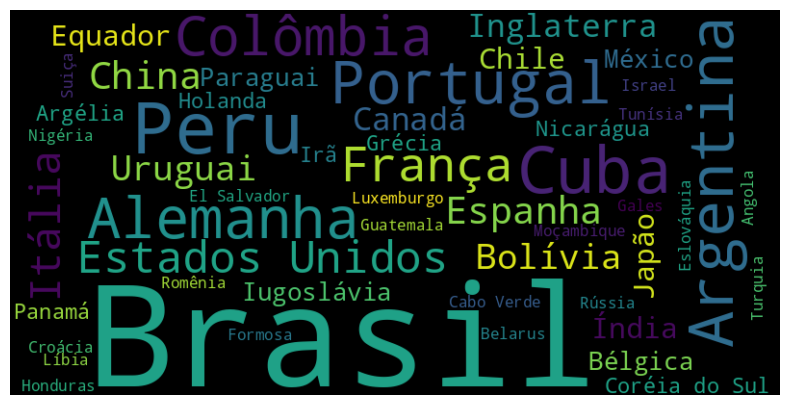

In [9]:
plot_df_columns_wordcloud(df_pesq, ['PAIS-DE-NASCIMENTO'])

## Areas

In [10]:
df_areas = pd.read_csv('../data/processed/aplicacoes/areas.csv')


In [11]:
print_dataframe_status(df_areas)

Shape: (16286, 6)
Contagem de dados nulos:


LattesID                               0
SEQUENCIA-AREA-DE-ATUACAO             26
NOME-GRANDE-AREA-DO-CONHECIMENTO       0
NOME-DA-AREA-DO-CONHECIMENTO          28
NOME-DA-SUB-AREA-DO-CONHECIMENTO    1462
NOME-DA-ESPECIALIDADE               8050
dtype: int64

Amostra do dataset:


LattesID  SEQUENCIA-AREA-DE-ATUACAO NOME-GRANDE-AREA-DO-CONHECIMENTO  \
0  565598534943                        5.0       CIENCIAS_EXATAS_E_DA_TERRA   
1  565598534943                        4.0       CIENCIAS_EXATAS_E_DA_TERRA   
2  565598534943                        3.0       CIENCIAS_EXATAS_E_DA_TERRA   
3  565598534943                        2.0       CIENCIAS_EXATAS_E_DA_TERRA   
4  565598534943                        1.0       CIENCIAS_EXATAS_E_DA_TERRA   

  NOME-DA-AREA-DO-CONHECIMENTO      NOME-DA-SUB-AREA-DO-CONHECIMENTO  \
0        Ciência da Computação  Metodologia e Técnicas da Computação   
1        Ciência da Computação              Processamento de Imagens   
2        Ciência da Computação              Processamento de Imagens   
3        Ciência da Computação  Metodologia e Técnicas da Computação   
4        Ciência da Computação  Metodologia e Técnicas da Computação   

          NOME-DA-ESPECIALIDADE  
0     Linguagens de Programação  
1                Visão Robótica  
2  Visão Computacional Aplicada  
3        Sistemas de Informação  
4        Engenharia de Software

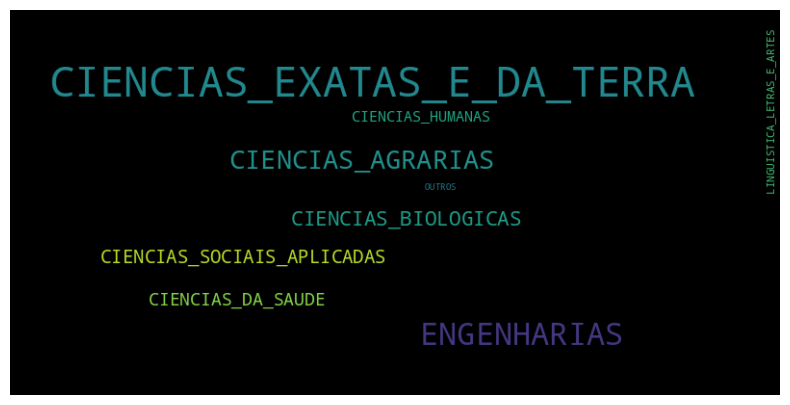

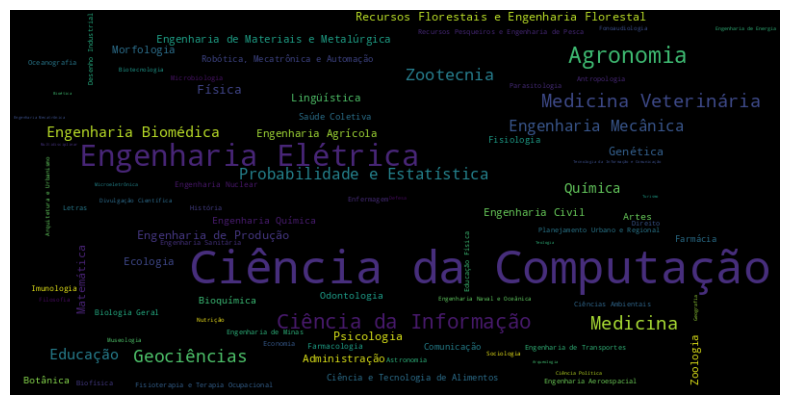

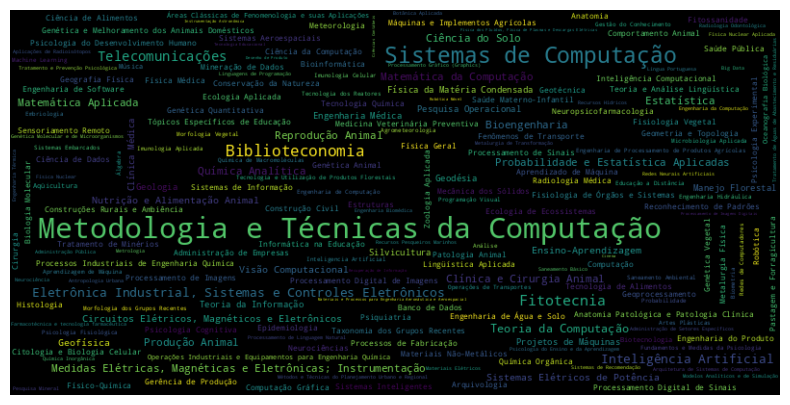

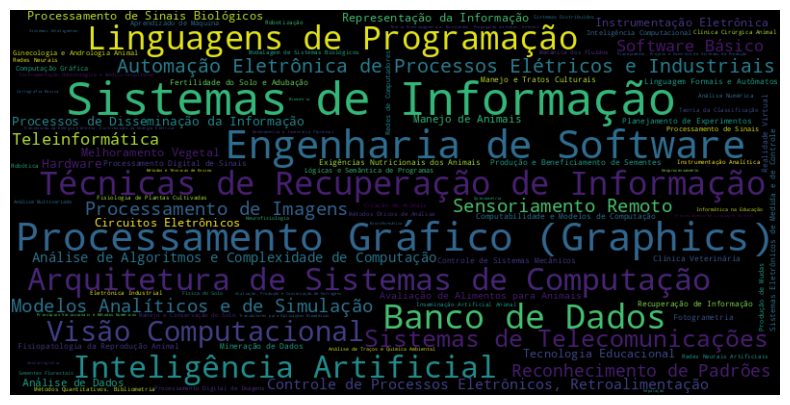

In [12]:
plot_df_columns_wordcloud(df_areas,['NOME-GRANDE-AREA-DO-CONHECIMENTO', 'NOME-DA-AREA-DO-CONHECIMENTO', 'NOME-DA-SUB-AREA-DO-CONHECIMENTO', 'NOME-DA-ESPECIALIDADE'])


In [13]:
# Lista das colunas que vamos analisar, excluindo 'LattesID'
cols_to_analyze = [col for col in df_areas.columns if col != "LattesID"]

In [14]:
print_value_counts(df_areas,5, cols_to_analyze)


=== ANÁLISE DESCRITIVA (TOP 5 POR COLUNA) ===

Coluna: SEQUENCIA-AREA-DE-ATUACAO
SEQUENCIA-AREA-DE-ATUACAO
1.0    3908
2.0    3715
3.0    3301
4.0    2561
5.0    1759
Name: count, dtype: int64
--------------------------------------------------
Coluna: NOME-GRANDE-AREA-DO-CONHECIMENTO
NOME-GRANDE-AREA-DO-CONHECIMENTO
CIENCIAS_EXATAS_E_DA_TERRA    6530
ENGENHARIAS                   3122
CIENCIAS_AGRARIAS             2212
CIENCIAS_BIOLOGICAS           1261
CIENCIAS_SOCIAIS_APLICADAS    1063
Name: count, dtype: int64
--------------------------------------------------
Coluna: NOME-DA-AREA-DO-CONHECIMENTO
NOME-DA-AREA-DO-CONHECIMENTO
Ciência da Computação    4862
Engenharia Elétrica      1514
Agronomia                 772
Ciência da Informação     641
Medicina Veterinária      498
Name: count, dtype: int64
--------------------------------------------------
Coluna: NOME-DA-SUB-AREA-DO-CONHECIMENTO
NOME-DA-SUB-AREA-DO-CONHECIMENTO
Metodologia e Técnicas da Computação    1608
NaN              

/tmp/ipykernel_1023707/166781012.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=45)


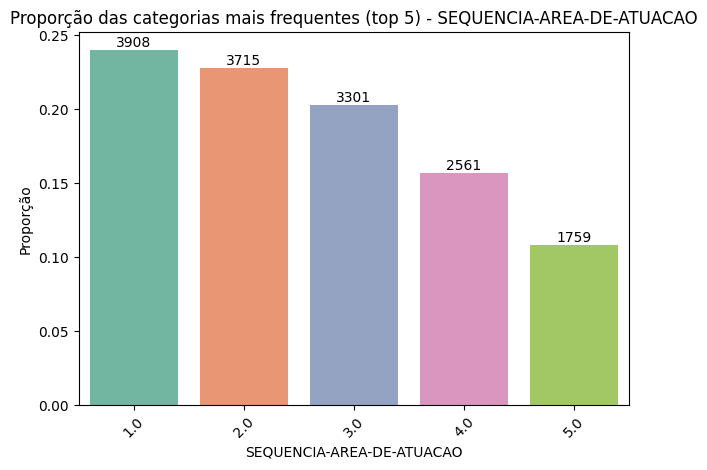

/tmp/ipykernel_1023707/166781012.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=45)


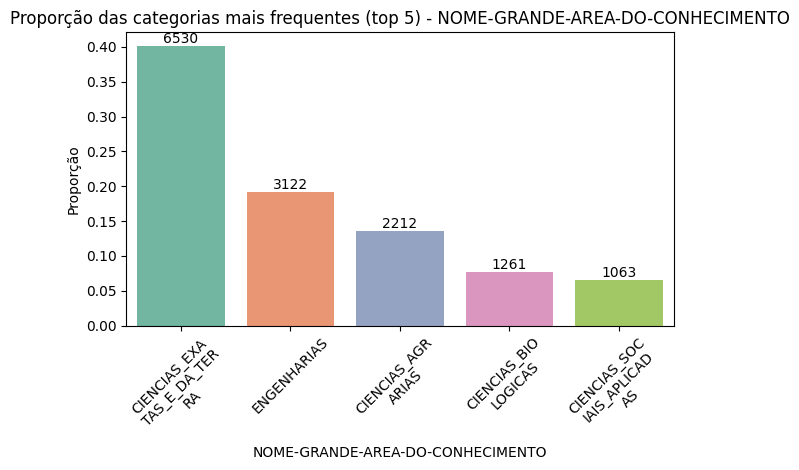

/tmp/ipykernel_1023707/166781012.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=45)


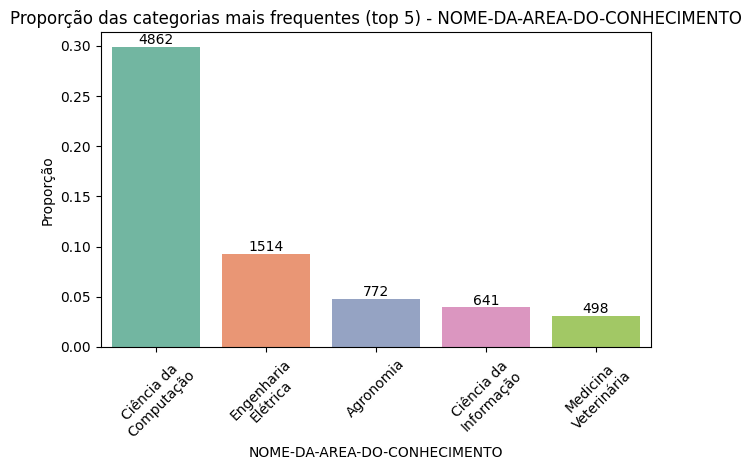

/tmp/ipykernel_1023707/166781012.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=45)


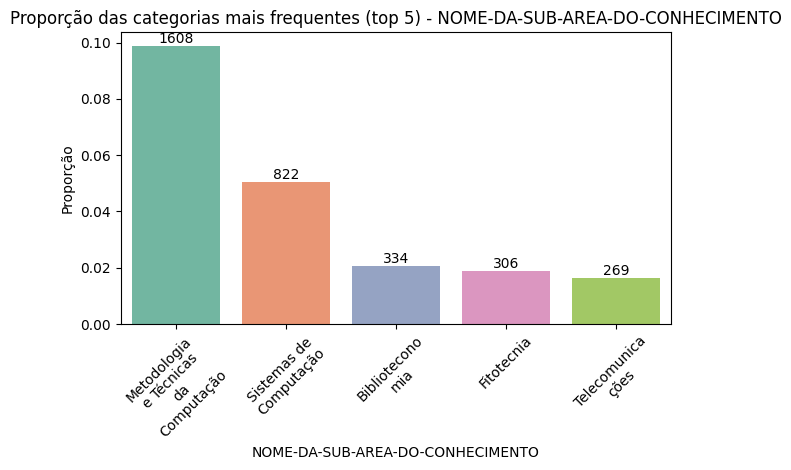

/tmp/ipykernel_1023707/166781012.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=45)


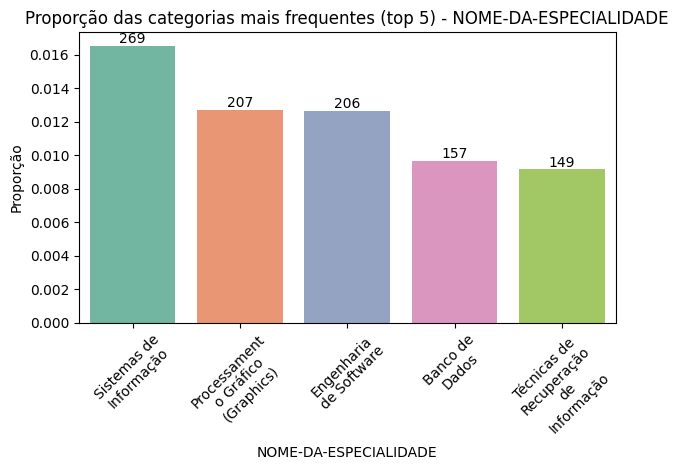

In [15]:
import textwrap


# -------------------------------------------------------------------
# Parâmetro: número máximo de categorias (barras) a exibir nos gráficos
# -------------------------------------------------------------------
n = 5

# Função para quebrar (wrap) os rótulos longos em múltiplas linhas
def wrap_labels(label, width=12):
    return "\n".join(textwrap.wrap(label, width=width))

# -------------------------------------------------------------------
# Geração dos gráficos de barras para cada coluna analisada
# -------------------------------------------------------------------
for col in cols_to_analyze:
    # Agrupa e conta as ocorrências para a coluna atual e seleciona as top n
    df_grouped = (
        df_areas
        .groupby(col)
        .size()
        .reset_index(name="count")
        .sort_values("count", ascending=False)
        .head(n)
    )
    # Calcula a proporção (em relação ao total do DataFrame)
    df_grouped["proportion"] = df_grouped["count"] / df_areas.shape[0]

    # Cria o gráfico utilizando Seaborn (não fixa o tamanho da figura)
    plt.figure()
    ax = sns.barplot(
        data=df_grouped,
        x=col,
        y="proportion",
        hue=col,       # utiliza a mesma coluna para atribuir cores
        palette="Set2" # ou outro palette de sua preferência
    )
    # Remove a legenda, pois o hue é idêntico ao eixo x
    if ax.get_legend() is not None:
        ax.get_legend().remove()

    plt.title(f"Proporção das categorias mais frequentes (top {n}) - {col}")
    plt.xlabel(col)
    plt.ylabel("Proporção")

    # Ajusta os rótulos do eixo x:
    # 1) Aplica uma rotação de 45°.
    # 2) Quebra (wrap) os rótulos para evitar sobreposição de textos longos.
    new_labels = [wrap_labels(label.get_text(), width=12) 
                  for label in ax.get_xticklabels()]
    ax.set_xticklabels(new_labels, rotation=45)

    # Adiciona as anotações (contagem) acima de cada barra
    for patch, (_, row) in zip(ax.patches, df_grouped.iterrows()):
        height = patch.get_height()
        ax.annotate(
            f'{int(row["count"])}',
            (patch.get_x() + patch.get_width() / 2., height),
            ha='center', va='center',
            textcoords='offset points', xytext=(0, 5)
        )

    plt.tight_layout()
    plt.show()


## Formações

In [16]:
df_forms = pd.read_csv('../data/processed/aplicacoes/formacoes.csv')

In [17]:
print_dataframe_status(df_forms)

Shape: (18236, 10)
Contagem de dados nulos:


LattesID                 0
SEQUENCIA-FORMACAO       0
NIVEL-FORMACAO           0
NIVEL                    0
ANO-DE-INICIO          382
ANO-DE-CONCLUSAO       793
STATUS-DO-CURSO        370
NOME-CURSO            3690
NOME-INSTITUICAO         5
FLAG-BOLSA             912
dtype: int64

Amostra do dataset:


LattesID  SEQUENCIA-FORMACAO NIVEL-FORMACAO NIVEL ANO-DE-INICIO  \
0  565598534943                   4      DOUTORADO     4          1987   
1  565598534943                   3       MESTRADO     3          1975   
2  565598534943                   1      GRADUACAO     1          1970   
3  601083852823                   4      DOUTORADO     4          2006   
4  601083852823                   3       MESTRADO     3          2003   

  ANO-DE-CONCLUSAO STATUS-DO-CURSO                           NOME-CURSO  \
0             1992       CONCLUIDO                  Computação Aplicada   
1             1976       CONCLUIDO  Engenharia de Sistemas e Computação   
2             1974       CONCLUIDO           Bacharelado Em Estatística   
3             2009       CONCLUIDO                          Estatística   
4             2005       CONCLUIDO                          Estatística   

                            NOME-INSTITUICAO FLAG-BOLSA  
0  Instituto Nacional de Pesquisas Espaciais        NAO  
1     Universidade Federal do Rio de Janeiro        NAO  
2    Escola Superior de Estatística da Bahia        NAO  
3                       Lancaster University        SIM  
4       Universidade Federal de Minas Gerais        SIM

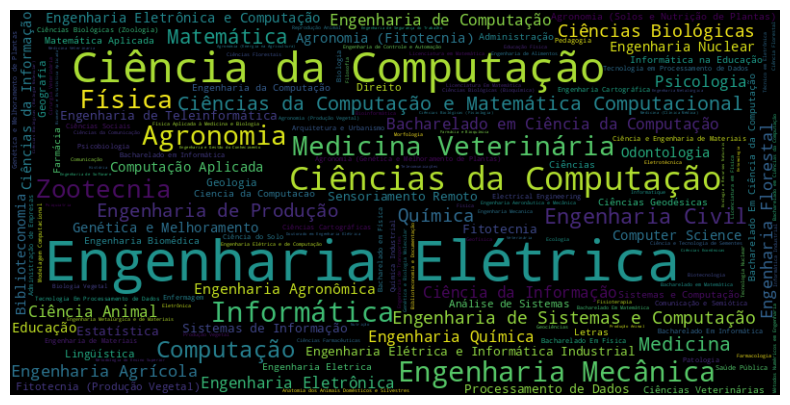

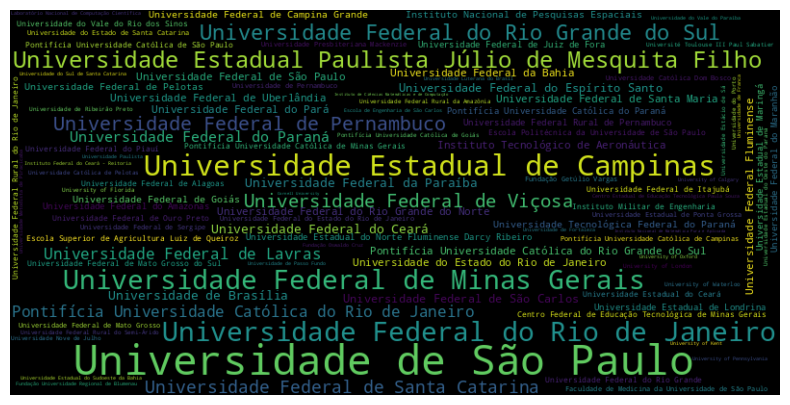

In [18]:
plot_df_columns_wordcloud(df_forms,["NOME-CURSO", "NOME-INSTITUICAO"])

In [19]:
# Lista das colunas a serem analisadas (excluindo 'LattesID')
cols_to_analyze = [col for col in df_forms.columns if col != "LattesID"]

In [20]:
print_value_counts(df_forms,5, cols_to_analyze)


=== ANÁLISE DESCRITIVA (TOP 5 POR COLUNA) ===

Coluna: SEQUENCIA-FORMACAO
SEQUENCIA-FORMACAO
1    3470
2    3130
3    2796
4    1817
5    1165
Name: count, dtype: int64
--------------------------------------------------
Coluna: NIVEL-FORMACAO
NIVEL-FORMACAO
GRADUACAO         4482
DOUTORADO         4088
MESTRADO          3814
POS-DOUTORADO     2427
ESPECIALIZACAO    1533
Name: count, dtype: int64
--------------------------------------------------
Coluna: NIVEL
NIVEL
1    4482
4    4088
3    3814
5    2427
2    1533
Name: count, dtype: int64
--------------------------------------------------
Coluna: ANO-DE-INICIO
ANO-DE-INICIO
2000    566
2005    562
2008    550
2001    548
2004    548
Name: count, dtype: int64
--------------------------------------------------
Coluna: ANO-DE-CONCLUSAO
ANO-DE-CONCLUSAO
NaN     793
2005    612
2003    605
2008    593
2006    578
Name: count, dtype: int64
--------------------------------------------------
Coluna: STATUS-DO-CURSO
STATUS-DO-CURSO
CONCLUIDO 

/tmp/ipykernel_1023707/326409561.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=45)


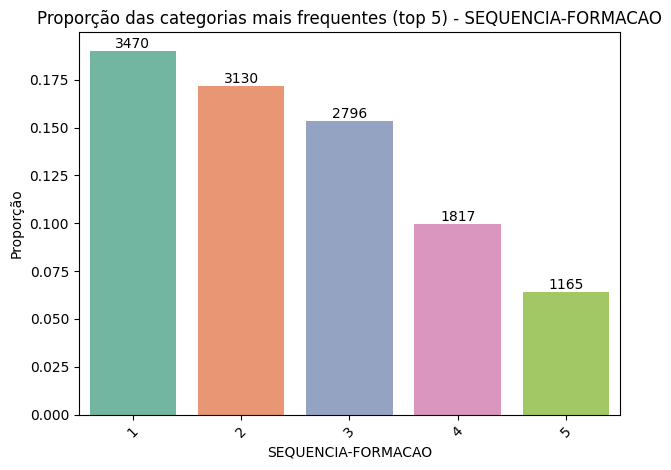

/tmp/ipykernel_1023707/326409561.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=45)


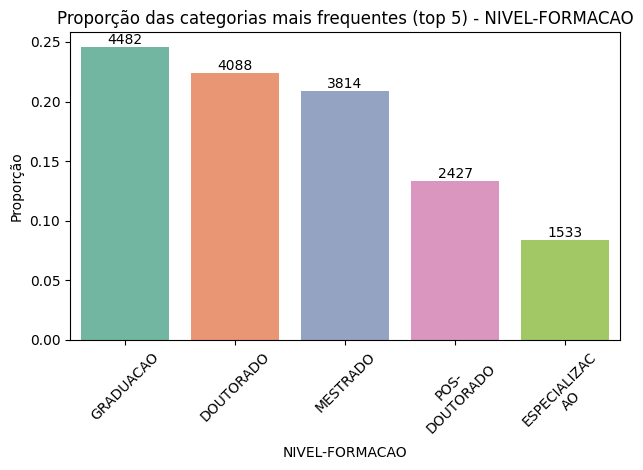

/tmp/ipykernel_1023707/326409561.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=45)


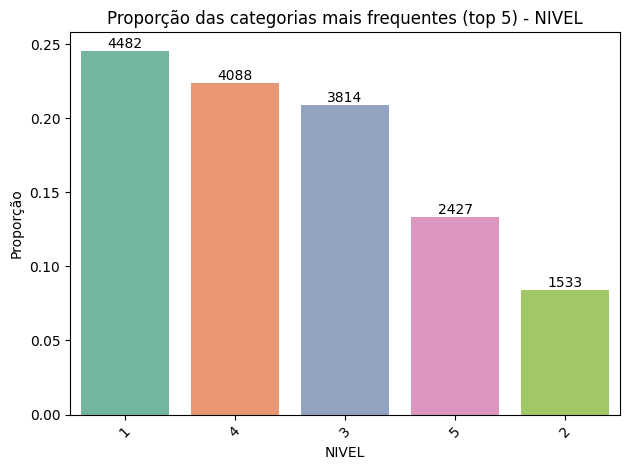

/tmp/ipykernel_1023707/326409561.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=45)


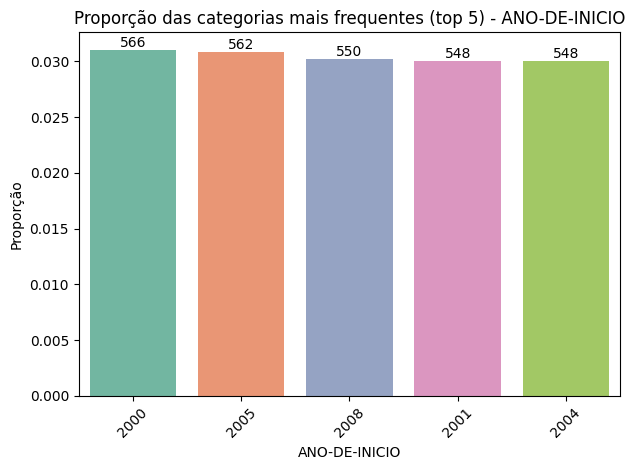

/tmp/ipykernel_1023707/326409561.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=45)


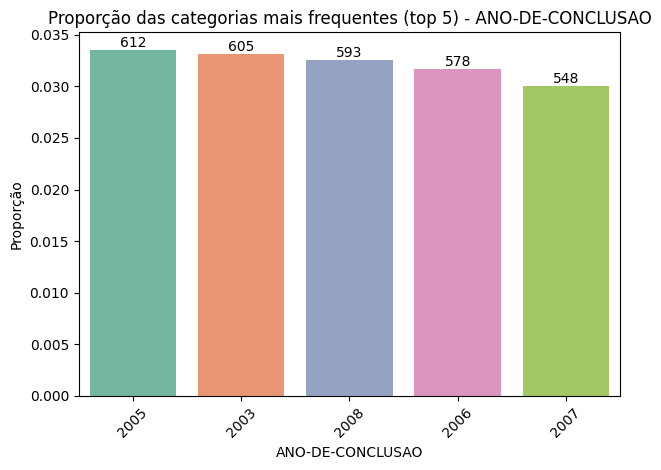

/tmp/ipykernel_1023707/326409561.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=45)


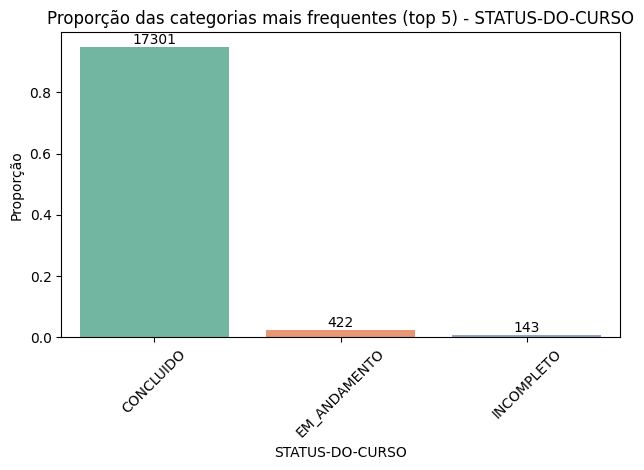

/tmp/ipykernel_1023707/326409561.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=45)


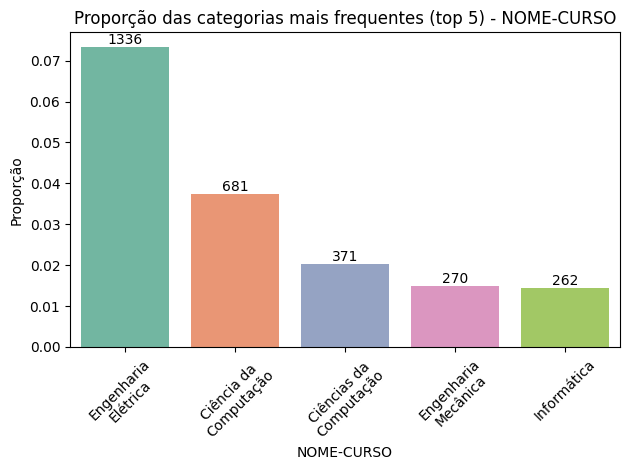

/tmp/ipykernel_1023707/326409561.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=45)


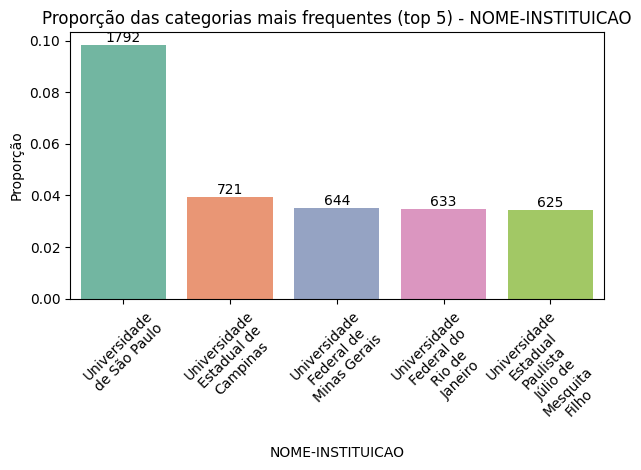

/tmp/ipykernel_1023707/326409561.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=45)


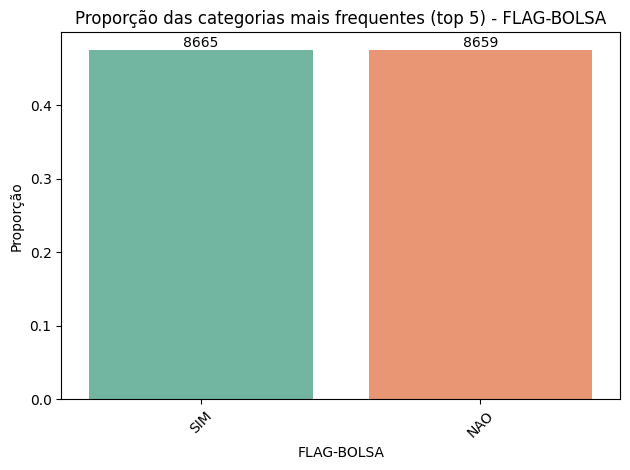

In [21]:
# -----------------------------------------------------------------------------
# Configuração: número máximo de categorias (barras) a exibir em cada gráfico
# -----------------------------------------------------------------------------
n = 5

# Função para quebrar (wrap) rótulos longos em múltiplas linhas
def wrap_labels(label, width=12):
    return "\n".join(textwrap.wrap(label, width=width))

# -----------------------------------------------------------------------------
# Geração dos gráficos de barras (top n) para cada coluna analisada
# -----------------------------------------------------------------------------
for col in cols_to_analyze:
    # Agrupa os dados por coluna, conta a frequência e seleciona top n
    df_grouped = (
        df_forms
        .groupby(col)
        .size()
        .reset_index(name="count")
        .sort_values("count", ascending=False)
        .head(n)
    )
    # Calcula a proporção em relação ao total de linhas do df_forms
    df_grouped["proportion"] = df_grouped["count"] / df_forms.shape[0]

    # Cria o gráfico de barras com Seaborn (sem tamanho fixo de figura)
    plt.figure()
    ax = sns.barplot(
        data=df_grouped,
        x=col,
        y="proportion",
        hue=col,         # usa a própria coluna como hue para colorir cada categoria
        palette="Set2"   # escolha a paleta desejada
    )
    # Remove a legenda (pois hue = col repete os valores do eixo x)
    if ax.get_legend() is not None:
        ax.get_legend().remove()

    plt.title(f"Proporção das categorias mais frequentes (top {n}) - {col}")
    plt.xlabel(col)
    plt.ylabel("Proporção")

    # Ajusta os rótulos do eixo x: rotação e quebra de linha para evitar sobreposição
    new_labels = [wrap_labels(label.get_text(), width=12) for label in ax.get_xticklabels()]
    ax.set_xticklabels(new_labels, rotation=45)

    # Adiciona as contagens em cima de cada barra
    for patch, (_, row) in zip(ax.patches, df_grouped.iterrows()):
        height = patch.get_height()
        ax.annotate(
            f'{int(row["count"])}',
            (patch.get_x() + patch.get_width() / 2., height),
            ha='center', va='center',
            xytext=(0, 5),  # deslocamento vertical
            textcoords='offset points'
        )

    plt.tight_layout()
    plt.show()




## Endereços

In [22]:
print_dataframe_status(df_end)

Shape: (3644, 11)
Contagem de dados nulos:


LattesID                         0
PAIS                             0
UF                              98
CIDADE                           1
CEP                             26
CODIGO-INSTITUICAO-EMPRESA      15
NOME-INSTITUICAO-EMPRESA        16
CODIGO-UNIDADE                2216
NOME-UNIDADE                  2216
CODIGO-ORGAO                   381
NOME-ORGAO                     381
dtype: int64

Amostra do dataset:


LattesID    PAIS  UF               CIDADE        CEP  \
0  11303079806761  Brasil  SP  Sao Jose dos Campos  12227-010   
1  29713017048136  Brasil  PR              Maringa   87020900   
2  10858860721392  Brasil  MG       Belo Horizonte   31980110   
3  77465042842971  Brasil  MG       João Monlevade   35931026   
4  57571113012412  Brasil  SP            Sao Paulo  05508-010   

  CODIGO-INSTITUICAO-EMPRESA  \
0               008700000009   
1               032900000005   
2               117800000006   
3               033400000004   
4               006700000002   

                           NOME-INSTITUICAO-EMPRESA CODIGO-UNIDADE  \
0         Instituto Nacional de Pesquisas Espaciais   008701001998   
1                  Universidade Estadual de Maringá            NaN   
2  Pontifícia Universidade Católica de Minas Gerais   117801001995   
3                Universidade Federal de Ouro Preto            NaN   
4                         Universidade de São Paulo   006716001992   

                                        NOME-UNIDADE  CODIGO-ORGAO  \
0                Divisão de Processamento de Imagens  008701000991   
1                                                NaN  032902000002   
2                             Sistemas de Informação  117801000999   
3                                                NaN           NaN   
4  Departamento de Engenharia de Sistemas Eletrôn...  006716000007   

                                 NOME-ORGAO  
0  Coordenação Geral de Observação da Terra  
1                 Centro de Ciências Exatas  
2                  Instituto de Informática  
3                                       NaN  
4                        Escola Politécnica

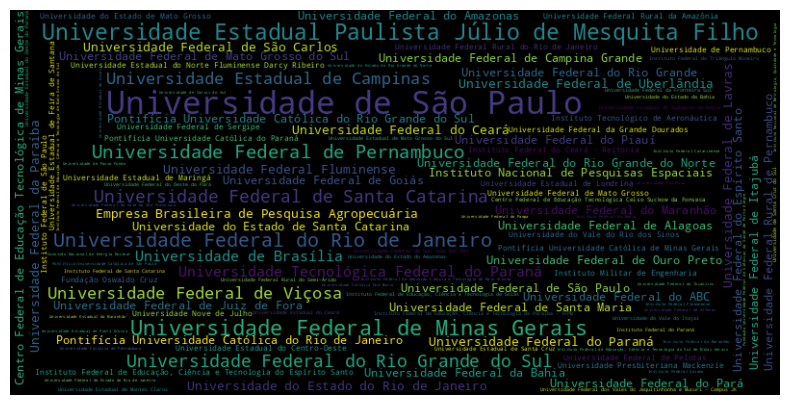

In [23]:
plot_df_columns_wordcloud(df_end, ["NOME-INSTITUICAO-EMPRESA"])

In [24]:
columns_to_analyze = ["NOME-INSTITUICAO-EMPRESA", "NOME-ORGAO"]

print_value_counts(df_end, 5, columns_to_analyze)


=== ANÁLISE DESCRITIVA (TOP 5 POR COLUNA) ===

Coluna: NOME-INSTITUICAO-EMPRESA
NOME-INSTITUICAO-EMPRESA
Universidade de São Paulo                                 259
Universidade Estadual Paulista Júlio de Mesquita Filho    118
Universidade Federal de Minas Gerais                      111
Universidade Federal do Rio de Janeiro                     92
Universidade Federal de Pernambuco                         86
Name: count, dtype: int64
--------------------------------------------------
Coluna: NOME-ORGAO
NOME-ORGAO
NaN                             381
Centro de Tecnologia             62
Centro Tecnológico               59
Instituto de Ciências Exatas     54
Escola Politécnica               53
Name: count, dtype: int64
--------------------------------------------------


/tmp/ipykernel_1023707/4238293866.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_inst.set_xticklabels(new_labels, rotation=45)


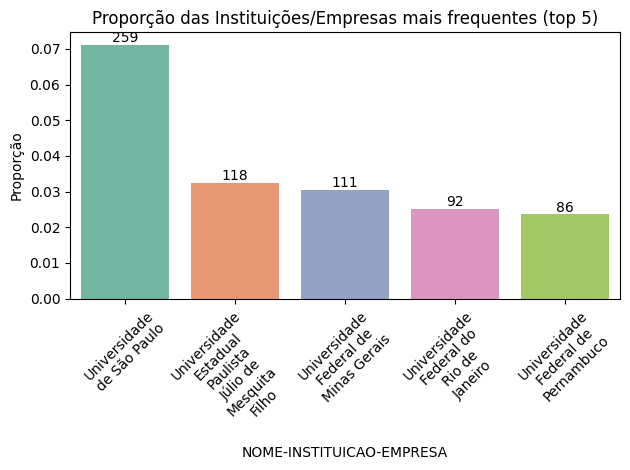

/tmp/ipykernel_1023707/4238293866.py:90: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_orgao.set_xticklabels(new_labels, rotation=45)


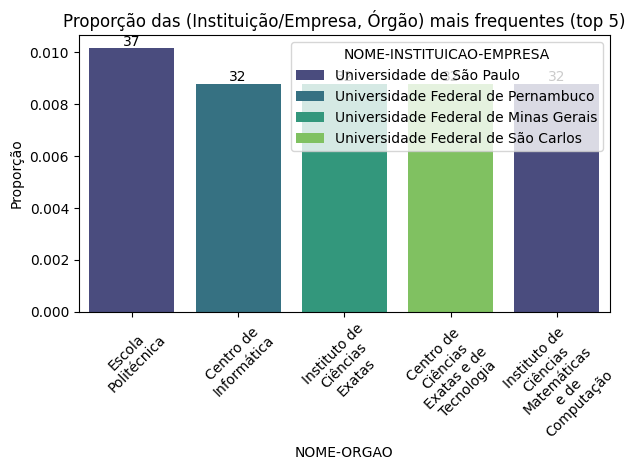

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap

n = 5  # Ajuste conforme desejar (por exemplo, 5, 10 etc.)

# -------------------------------------------------------------------------
# Função para "quebrar" (wrap) rótulos longos em múltiplas linhas
# -------------------------------------------------------------------------
def wrap_labels(label, width=12):
    return "\n".join(textwrap.wrap(label, width=width))

# -------------------------------------------------------------------------
# 1. GRÁFICO DE BARRA PARA `NOME-INSTITUICAO-EMPRESA` (top n)
# -------------------------------------------------------------------------
df_instituicao = (
    df_end
    .groupby("NOME-INSTITUICAO-EMPRESA")
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
    .head(n)
)
df_instituicao["proportion"] = df_instituicao["count"] / df_end.shape[0]

plt.figure()
ax_inst = sns.barplot(
    data=df_instituicao,
    x="NOME-INSTITUICAO-EMPRESA",
    y="proportion",
    hue="NOME-INSTITUICAO-EMPRESA",  # usa a própria coluna para dar cor
    palette="Set2"
)
# Remove a legenda redundante
if ax_inst.get_legend() is not None:
    ax_inst.get_legend().remove()

plt.title(f"Proporção das Instituições/Empresas mais frequentes (top {n})")
plt.xlabel("NOME-INSTITUICAO-EMPRESA")
plt.ylabel("Proporção")

# Ajusta rótulos do eixo x: rotação + quebra de linha
new_labels = [wrap_labels(label.get_text(), width=12) for label in ax_inst.get_xticklabels()]
ax_inst.set_xticklabels(new_labels, rotation=45)

# Anota as contagens sobre cada barra
for patch, (_, row) in zip(ax_inst.patches, df_instituicao.iterrows()):
    height = patch.get_height()
    ax_inst.annotate(
        f'{int(row["count"])}',
        (patch.get_x() + patch.get_width() / 2., height),
        ha='center',
        va='center',
        xytext=(0, 5),
        textcoords='offset points'
    )

plt.tight_layout()
plt.show()

# -------------------------------------------------------------------------
# 2. GRÁFICO DE BARRA PARA O PAR (`NOME-INSTITUICAO-EMPRESA`, `NOME-ORGAO`) (top n)
#    Este é análogo a (Cidade, UF) em exemplos anteriores.
# -------------------------------------------------------------------------
df_orgao = (
    df_end
    .groupby(["NOME-INSTITUICAO-EMPRESA", "NOME-ORGAO"])
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
    .head(n)
)
df_orgao["proportion"] = df_orgao["count"] / df_end.shape[0]

plt.figure()
ax_orgao = sns.barplot(
    data=df_orgao,
    x="NOME-ORGAO",
    y="proportion",
    hue="NOME-INSTITUICAO-EMPRESA",   # cor baseada na Instituição/Empresa
    palette="viridis"
)
plt.title(f"Proporção das (Instituição/Empresa, Órgão) mais frequentes (top {n})")
plt.xlabel("NOME-ORGAO")
plt.ylabel("Proporção")

# Rótulos do eixo x: rotação + wrap
new_labels = [wrap_labels(label.get_text(), width=12) for label in ax_orgao.get_xticklabels()]
ax_orgao.set_xticklabels(new_labels, rotation=45)

# Adiciona as contagens
for patch, (_, row) in zip(ax_orgao.patches, df_orgao.iterrows()):
    height = patch.get_height()
    ax_orgao.annotate(
        f'{int(row["count"])}',
        (patch.get_x() + patch.get_width() / 2., height),
        ha='center',
        va='center',
        xytext=(0, 5),
        textcoords='offset points'
    )

plt.tight_layout()
plt.show()

## Linhas

In [26]:
df_linhas = pd.read_csv('../data/processed/aplicacoes/linhas.csv')

In [27]:
print_dataframe_status(df_linhas)

Shape: (7271, 15)
Contagem de dados nulos:


LattesID                               0
TITULO-DA-LINHA-DE-PESQUISA            1
OBJETIVOS-LINHA-DE-PESQUISA         2935
FLAG-LINHA-DE-PESQUISA-ATIVA           0
PALAVRA-CHAVE-1                     2820
PALAVRA-CHAVE-2                     3122
PALAVRA-CHAVE-3                     3745
PALAVRA-CHAVE-4                     4922
PALAVRA-CHAVE-5                     5777
SETOR-DE-ATIVIDADE-1                4690
SETOR-DE-ATIVIDADE-2                6335
NOME-GRANDE-AREA-DO-CONHECIMENTO    3359
NOME-DA-AREA-DO-CONHECIMENTO        7089
NOME-DA-SUB-AREA-DO-CONHECIMENTO    4373
NOME-DA-ESPECIALIDADE               5620
dtype: int64

Amostra do dataset:


LattesID             TITULO-DA-LINHA-DE-PESQUISA  \
0  11303079806761  ASPECTS STOCHASTIQUES DE L'AUTOMATIQUE   
1  11303079806761                   Morfologia matemática   
2  11303079806761        Processamento digital de imagens   
3  51564735964760              Teorias das Singularidades   
4  32127633683659   Produção de sentido no texto/discurso   

                         OBJETIVOS-LINHA-DE-PESQUISA  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4  Examinar tanto os procedimentos de organização...   

  FLAG-LINHA-DE-PESQUISA-ATIVA PALAVRA-CHAVE-1 PALAVRA-CHAVE-2  \
0                          NAO             NaN             NaN   
1                          NAO             NaN             NaN   
2                          NAO             NaN             NaN   
3                          SIM             NaN             NaN   
4                          NAO             NaN             NaN   

  PALAVRA-CHAVE-3 PALAVRA-CHAVE-4 PALAVRA-CHAVE-5 SETOR-DE-ATIVIDADE-1  \
0             NaN             NaN             NaN                  NaN   
1             NaN             NaN             NaN                  NaN   
2             NaN             NaN             NaN                  NaN   
3             NaN             NaN             NaN             Educação   
4             NaN             NaN             NaN                  NaN   

  SETOR-DE-ATIVIDADE-2 NOME-GRANDE-AREA-DO-CONHECIMENTO  \
0                  NaN                              NaN   
1                  NaN                              NaN   
2                  NaN                              NaN   
3                  NaN       CIENCIAS_EXATAS_E_DA_TERRA   
4                  NaN       LINGUISTICA_LETRAS_E_ARTES   

  NOME-DA-AREA-DO-CONHECIMENTO NOME-DA-SUB-AREA-DO-CONHECIMENTO  \
0                          NaN                              NaN   
1                          NaN                              NaN   
2                          NaN                              NaN   
3                          NaN            Geometria e Topologia   
4                          NaN     Teoria e Análise Lingüística   

                               NOME-DA-ESPECIALIDADE  
0                                                NaN  
1                                                NaN  
2                                                NaN  
3  Teoria das Singularidades e Teoria das Catástr...  
4                                                NaN

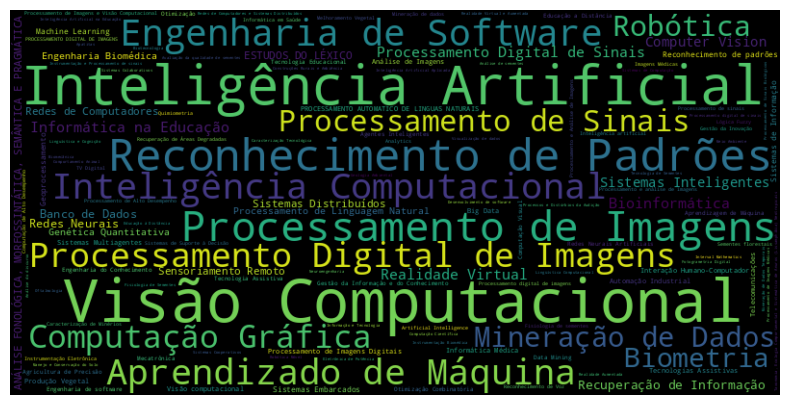

In [28]:
plot_df_columns_wordcloud(df_linhas, ["TITULO-DA-LINHA-DE-PESQUISA"])

TEM POUQUISSIMO DADO NAO NULO, VALE ANALISE?

In [29]:
print_value_counts(df_linhas, 5, ["TITULO-DA-LINHA-DE-PESQUISA"])


=== ANÁLISE DESCRITIVA (TOP 5 POR COLUNA) ===

Coluna: TITULO-DA-LINHA-DE-PESQUISA
TITULO-DA-LINHA-DE-PESQUISA
Visão Computacional          63
Inteligência Artificial      51
Reconhecimento de Padrões    32
Processamento de Imagens     28
Engenharia de Software       21
Name: count, dtype: int64
--------------------------------------------------


/tmp/ipykernel_1023707/1711134032.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=45)


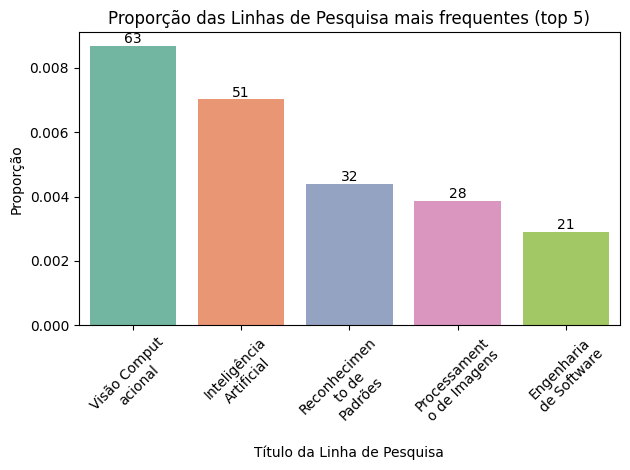

In [30]:
# ===================================
# Parâmetro: número de categorias (barras) a exibir
# ===================================
n = 5  # ajuste conforme necessário (ex: 5, 10 etc.)

# ===================================
# Função para quebrar (wrap) rótulos longos
# ===================================
def wrap_labels(label, width=12):
    return "\n".join(textwrap.wrap(label, width=width))

# ===================================
# 1. AGRUPAMENTO E GRÁFICO DE BARRA
#    para a coluna `TITULO-DA-LINHA-DE-PESQUISA`
# ===================================
df_titulo = (
    df_linhas
    .groupby("TITULO-DA-LINHA-DE-PESQUISA")  # agrupa pela coluna
    .size()                                 # conta quantas vezes cada valor ocorre
    .reset_index(name="count")
    .sort_values("count", ascending=False)
    .head(n)
)
# Calcula a proporção em relação ao total de registros do df_linhas
df_titulo["proportion"] = df_titulo["count"] / df_linhas.shape[0]

# Criando o gráfico de barras
plt.figure()  # não definimos figsize para deixar livre
ax = sns.barplot(
    data=df_titulo,
    x="TITULO-DA-LINHA-DE-PESQUISA",
    y="proportion",
    hue="TITULO-DA-LINHA-DE-PESQUISA",  # usar a própria coluna como hue
    palette="Set2"                      # escolha uma paleta de cores
)
# Removemos a legenda, pois seria redundante (hue = x)
if ax.get_legend() is not None:
    ax.get_legend().remove()

# Título e rótulos
plt.title(f"Proporção das Linhas de Pesquisa mais frequentes (top {n})")
plt.xlabel("Título da Linha de Pesquisa")
plt.ylabel("Proporção")

# Ajuste dos rótulos do eixo x: rotação e quebra de texto longo
new_labels = [wrap_labels(label.get_text(), width=12) for label in ax.get_xticklabels()]
ax.set_xticklabels(new_labels, rotation=45)

# Adicionando as contagens em cima de cada barra
for patch, (_, row) in zip(ax.patches, df_titulo.iterrows()):
    height = patch.get_height()
    ax.annotate(
        f'{int(row["count"])}',
        (patch.get_x() + patch.get_width() / 2., height),
        ha='center',
        va='center',
        xytext=(0, 5),
        textcoords='offset points'
    )

plt.tight_layout()
plt.show()

## Projetos

In [31]:
df_proj = pd.read_csv('../data/processed/aplicacoes/projetos.csv')

In [32]:
print_dataframe_status(df_proj)

Shape: (53045, 14)
Contagem de dados nulos:


LattesID                  0
NATUREZA               1067
SITUACAO               1067
NOME-DO-PROJETO        1067
ANO-INICIO                5
ANO-FIM               15572
FLAG-RESPONSAVEL       1097
CODIGO-INSTITUICAO    24684
NOME-INSTITUICAO      24684
CODIGO-UNIDADE        36825
NOME-UNIDADE          36825
CODIGO-ORGAO            114
NOME-ORGAO              114
INTEGRANTES            1096
dtype: int64

Amostra do dataset:


LattesID  NATUREZA      SITUACAO  \
0  29713017048136  EXTENSAO     CONCLUIDO   
1  29713017048136  EXTENSAO     CONCLUIDO   
2  29713017048136  PESQUISA  EM_ANDAMENTO   
3  29713017048136  PESQUISA     CONCLUIDO   
4  29713017048136  PESQUISA     CONCLUIDO   

                                     NOME-DO-PROJETO  ANO-INICIO  ANO-FIM  \
0  Projeto de Aperfeiçoamento de professores de m...      1997.0   1998.0   
1  Programa de Acompanhamento dos alunos dos curs...      2001.0   2001.0   
2  ANÁLISE WAVELET: DETECÇÃO E REDUÇÃO DO MULTICA...      2004.0      NaN   
3  Countering the Effects of Ionospheric Scintill...      2007.0      NaN   
4  Projeto Temático FAPESP - GNSS: investigações ...      2008.0   2012.0   

  FLAG-RESPONSAVEL CODIGO-INSTITUICAO  \
0              NAO       037700000002   
1              NAO       037700000002   
2              NAO       037700000002   
3              NAO       037700000002   
4              NAO       037700000002   

                                    NOME-INSTITUICAO CODIGO-UNIDADE  \
0  Fundação de Amparo à Pesquisa do Estado de São...   033012006005   
1  Fundação de Amparo à Pesquisa do Estado de São...   033012005009   
2  Fundação de Amparo à Pesquisa do Estado de São...   033012004002   
3  Fundação de Amparo à Pesquisa do Estado de São...            NaN   
4  Fundação de Amparo à Pesquisa do Estado de São...            NaN   

                  NOME-UNIDADE  CODIGO-ORGAO  \
0     Departamento de Educação  033012000007   
1   Departamento de Matemática  033012000007   
2  Departamento de Cartografia  033012000007   
3                          NaN  033012000007   
4                          NaN  033012000007   

                                          NOME-ORGAO  \
0  Faculdade de Ciências e Tecnologia de Presiden...   
1  Faculdade de Ciências e Tecnologia de Presiden...   
2  Faculdade de Ciências e Tecnologia de Presiden...   
3  Faculdade de Ciências e Tecnologia de Presiden...   
4  Faculdade de Ciências e Tecnologia de Presiden...   

                                         INTEGRANTES  
0   Vinicio de Macedo Santos#Eniuce Menezes de Souza  
1  Aparecida Doniseti Pires de Souza#Eniuce Menez...  
2  Guilherme Polezuk S Rosa#Luiz Fernando Dalbell...  
3  Marcio Aquino#Haroldo Antonio Marques#Heloísa ...  
4  Paulo de Oliveira Camargo#João Francisco Galer...

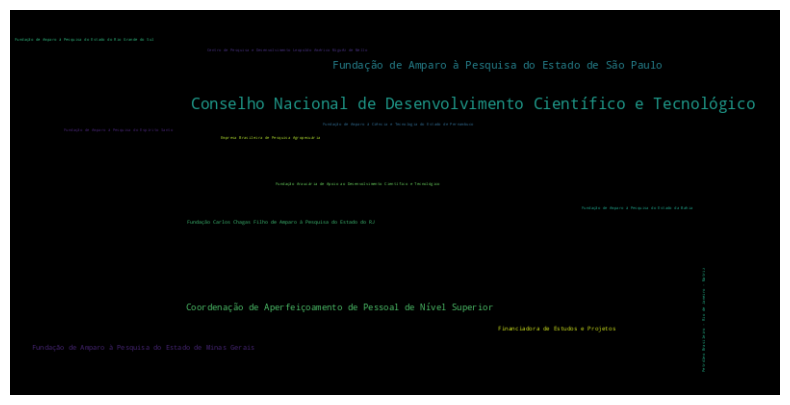

In [33]:
plot_df_columns_wordcloud(df_proj, ["NOME-INSTITUICAO"])

GOSTARIA DE CONTAR OS NOMES DOS INTEGRANTES, MAS COMO FAZER ISSO DADO QUE TEM DUPLICATAS DE PROJETOS?

In [34]:
print_value_counts(df_proj, 5, ["NATUREZA", "SITUACAO"])


=== ANÁLISE DESCRITIVA (TOP 5 POR COLUNA) ===

Coluna: NATUREZA
NATUREZA
PESQUISA           39999
EXTENSAO            5243
DESENVOLVIMENTO     4727
OUTRA               1632
NaN                 1067
Name: count, dtype: int64
--------------------------------------------------
Coluna: SITUACAO
SITUACAO
CONCLUIDO       34853
EM_ANDAMENTO    16378
NaN              1067
DESATIVADO        747
Name: count, dtype: int64
--------------------------------------------------


/tmp/ipykernel_1023707/81763666.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_nat.set_xticklabels(new_labels, rotation=45)


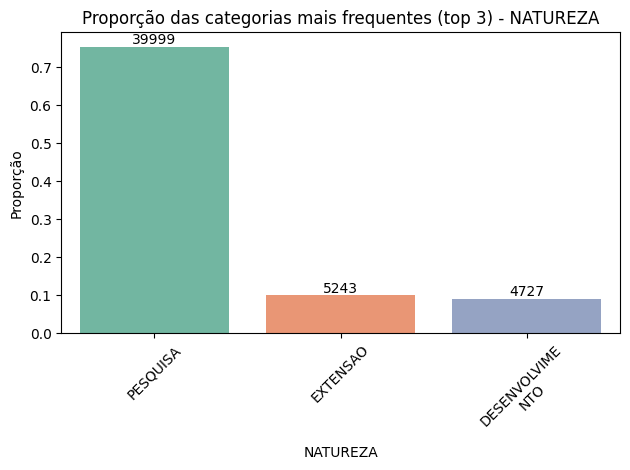

/tmp/ipykernel_1023707/81763666.py:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_sit.set_xticklabels(new_labels, rotation=45)


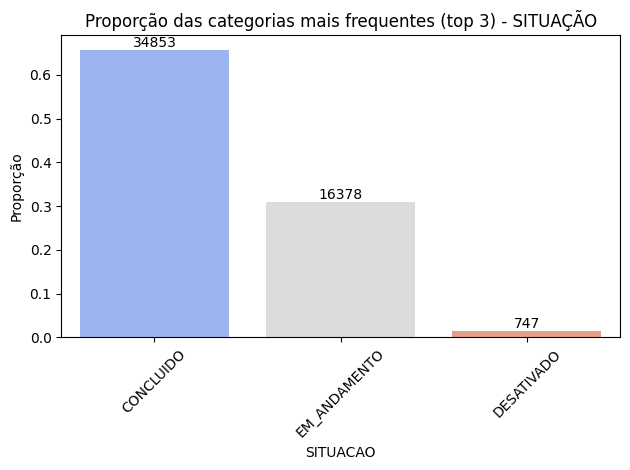

/tmp/ipykernel_1023707/81763666.py:118: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax_inicio = sns.barplot(
/tmp/ipykernel_1023707/81763666.py:129: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_inicio.set_xticklabels(ax_inicio.get_xticklabels(), rotation=45)


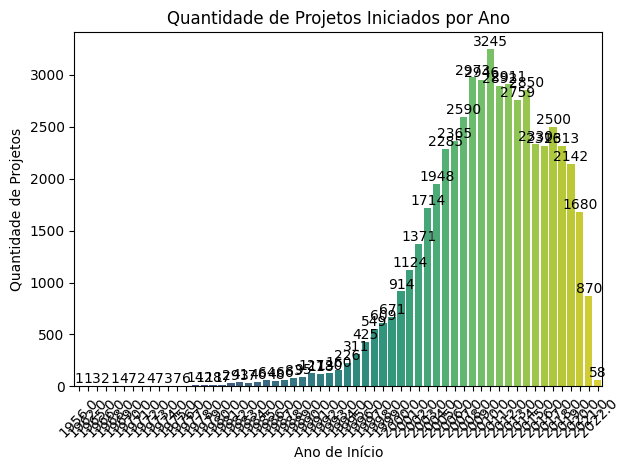

/tmp/ipykernel_1023707/81763666.py:158: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax_fim = sns.barplot(
/tmp/ipykernel_1023707/81763666.py:168: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_fim.set_xticklabels(ax_fim.get_xticklabels(), rotation=45)


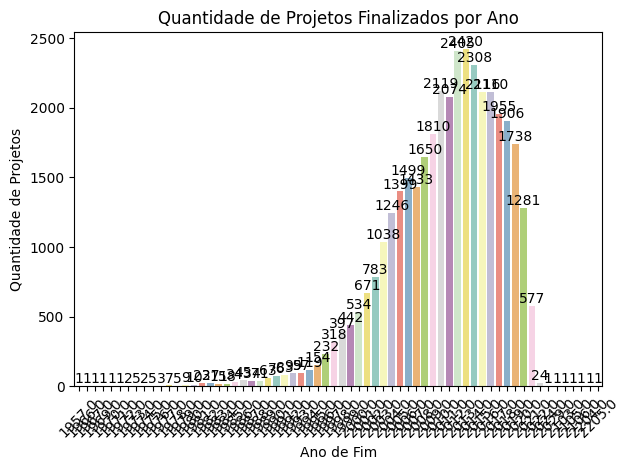

In [35]:
# --------------------------------------------------------------------
# 1. Parâmetro: número de categorias (barras) a exibir para NATUREZA e SITUAÇÃO
# --------------------------------------------------------------------
n = 3  # Ajuste conforme necessário

# --------------------------------------------------------------------
# Função para "quebrar" (wrap) rótulos longos em múltiplas linhas
# --------------------------------------------------------------------
def wrap_labels(label, width=12):
    return "\n".join(textwrap.wrap(label, width=width))

# --------------------------------------------------------------------
# 2. Análise para a Coluna `NATUREZA`
# --------------------------------------------------------------------
df_nat = (
    df_proj
    .groupby("NATUREZA")
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
    .head(n)
)
df_nat["proportion"] = df_nat["count"] / df_proj.shape[0]

plt.figure()
ax_nat = sns.barplot(
    data=df_nat,
    x="NATUREZA",
    y="proportion",
    hue="NATUREZA",    # usar a própria coluna para colorir cada barra
    palette="Set2"
)
# Remove legenda redundante
if ax_nat.get_legend() is not None:
    ax_nat.get_legend().remove()

plt.title(f"Proporção das categorias mais frequentes (top {n}) - NATUREZA")
plt.xlabel("NATUREZA")
plt.ylabel("Proporção")

# Ajuste dos rótulos do eixo x (rotação + quebra de linha)
new_labels = [wrap_labels(label.get_text(), width=12) for label in ax_nat.get_xticklabels()]
ax_nat.set_xticklabels(new_labels, rotation=45)

# Anota a contagem no topo de cada barra
for patch, (_, row) in zip(ax_nat.patches, df_nat.iterrows()):
    height = patch.get_height()
    ax_nat.annotate(
        f'{int(row["count"])}',
        (patch.get_x() + patch.get_width() / 2., height),
        ha='center', va='center',
        xytext=(0, 5),
        textcoords='offset points'
    )

plt.tight_layout()
plt.show()

# --------------------------------------------------------------------
# 3. Análise para a Coluna `SITUAÇÃO`
# --------------------------------------------------------------------
df_sit = (
    df_proj
    .groupby("SITUACAO")
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
    .head(n)
)
df_sit["proportion"] = df_sit["count"] / df_proj.shape[0]

plt.figure()
ax_sit = sns.barplot(
    data=df_sit,
    x="SITUACAO",
    y="proportion",
    hue="SITUACAO",    # usar a própria coluna para colorir cada barra
    palette="coolwarm"
)
# Remove legenda redundante
if ax_sit.get_legend() is not None:
    ax_sit.get_legend().remove()

plt.title(f"Proporção das categorias mais frequentes (top {n}) - SITUAÇÃO")
plt.xlabel("SITUACAO")
plt.ylabel("Proporção")

new_labels = [wrap_labels(label.get_text(), width=12) for label in ax_sit.get_xticklabels()]
ax_sit.set_xticklabels(new_labels, rotation=45)

for patch, (_, row) in zip(ax_sit.patches, df_sit.iterrows()):
    height = patch.get_height()
    ax_sit.annotate(
        f'{int(row["count"])}',
        (patch.get_x() + patch.get_width() / 2., height),
        ha='center', va='center',
        xytext=(0, 5),
        textcoords='offset points'
    )

plt.tight_layout()
plt.show()

# --------------------------------------------------------------------
# 4. Análise Temporal - ANO-INICIO (Projetos Iniciados)
# --------------------------------------------------------------------
# Agrupamos por ANO-INICIO para ver quantos projetos foram iniciados em cada ano
df_inicio = (
    df_proj
    .dropna(subset=["ANO-INICIO"])     # caso queira ignorar projetos sem ano de início
    .groupby("ANO-INICIO")
    .size()
    .reset_index(name="count_start")
    .sort_values("ANO-INICIO")
)

plt.figure()
ax_inicio = sns.barplot(
    data=df_inicio,
    x="ANO-INICIO",
    y="count_start",
    palette="viridis"
)
plt.title("Quantidade de Projetos Iniciados por Ano")
plt.xlabel("Ano de Início")
plt.ylabel("Quantidade de Projetos")

# Rotação dos rótulos no eixo x (caso tenha muitos anos)
ax_inicio.set_xticklabels(ax_inicio.get_xticklabels(), rotation=45)

# Anota o valor em cima das barras
for patch, (_, row) in zip(ax_inicio.patches, df_inicio.iterrows()):
    height = patch.get_height()
    ax_inicio.annotate(
        f'{int(row["count_start"])}',
        (patch.get_x() + patch.get_width() / 2., height),
        ha='center', va='center',
        xytext=(0, 5),
        textcoords='offset points'
    )
plt.tight_layout()
plt.show()

# --------------------------------------------------------------------
# 5. Análise Temporal - ANO-FIM (Projetos Finalizados)
# --------------------------------------------------------------------
# Agrupamos por ANO-FIM para ver quantos projetos foram finalizados em cada ano
df_fim = (
    df_proj
    .dropna(subset=["ANO-FIM"])       # caso queira ignorar projetos sem ano de término
    .groupby("ANO-FIM")
    .size()
    .reset_index(name="count_end")
    .sort_values("ANO-FIM")
)

plt.figure()
ax_fim = sns.barplot(
    data=df_fim,
    x="ANO-FIM",
    y="count_end",
    palette="Set3"
)
plt.title("Quantidade de Projetos Finalizados por Ano")
plt.xlabel("Ano de Fim")
plt.ylabel("Quantidade de Projetos")

ax_fim.set_xticklabels(ax_fim.get_xticklabels(), rotation=45)

for patch, (_, row) in zip(ax_fim.patches, df_fim.iterrows()):
    height = patch.get_height()
    ax_fim.annotate(
        f'{int(row["count_end"])}',
        (patch.get_x() + patch.get_width() / 2., height),
        ha='center', va='center',
        xytext=(0, 5),
        textcoords='offset points'
    )
plt.tight_layout()
plt.show()

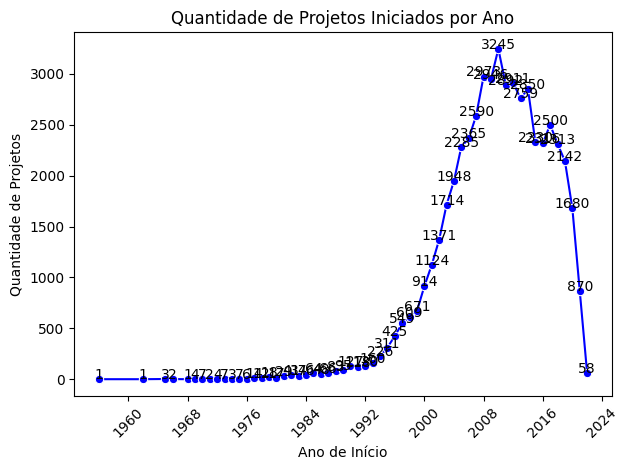

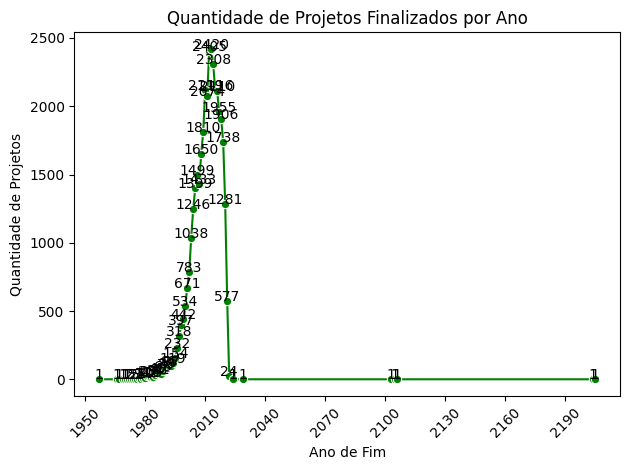

In [36]:
from matplotlib.ticker import MaxNLocator


# ============================================================================
# 2. Análise Temporal para ANO-INICIO e ANO-FIM (Gráficos de linha com eixo contínuo)
# ============================================================================

# --- Projetos Iniciados (ANO-INICIO) ---
df_inicio = (
    df_proj
    .dropna(subset=["ANO-INICIO"])  # ignora projetos sem ano de início, se houver
    .groupby("ANO-INICIO")
    .size()
    .reset_index(name="count_start")
    .sort_values("ANO-INICIO")
)

plt.figure()
ax_inicio = sns.lineplot(
    data=df_inicio,
    x="ANO-INICIO",
    y="count_start",
    marker="o",
    sort=True,
    color="blue"
)
plt.title("Quantidade de Projetos Iniciados por Ano")
plt.xlabel("Ano de Início")
plt.ylabel("Quantidade de Projetos")

# Configura o eixo x como contínuo, limitando o número de ticks (ex.: máximo 10)
ax_inicio.xaxis.set_major_locator(MaxNLocator(nbins=10))
plt.xticks(rotation=45)

# Anota os valores acima dos pontos
for index, row in df_inicio.iterrows():
    plt.text(row["ANO-INICIO"], row["count_start"] + 0.5, int(row["count_start"]), ha='center')

plt.tight_layout()
plt.show()

# --- Projetos Finalizados (ANO-FIM) ---
df_fim = (
    df_proj
    .dropna(subset=["ANO-FIM"])  # ignora projetos sem ano de fim, se houver
    .groupby("ANO-FIM")
    .size()
    .reset_index(name="count_end")
    .sort_values("ANO-FIM")
)

plt.figure()
ax_fim = sns.lineplot(
    data=df_fim,
    x="ANO-FIM",
    y="count_end",
    marker="o",
    sort=True,
    color="green"
)
plt.title("Quantidade de Projetos Finalizados por Ano")
plt.xlabel("Ano de Fim")
plt.ylabel("Quantidade de Projetos")

ax_fim.xaxis.set_major_locator(MaxNLocator(nbins=10))
plt.xticks(rotation=45)

for index, row in df_fim.iterrows():
    plt.text(row["ANO-FIM"], row["count_end"] + 0.5, int(row["count_end"]), ha='center')

plt.tight_layout()
plt.show()